<h2> Задача: </h2>

Решить уравнение Лапласа в прямоугольнике $\left[ 0 , 4\right] \times  \left[ 0 , 2\right]$

$
\begin{cases}
   \Delta \varphi (x, y)  = 0, \\
   \varphi (x, 0) = \varphi (0, y) = \varphi (4, y) = 0, \\
   \varphi (x, 2) = 10.
\end{cases}
$


Точное решение:

$
\displaystyle
\varphi\left(x, y\right) = \sum_{n = 1}^{\infty} \dfrac{20 \left(1 - (-1)^n \right)}{\pi n \left[ exp\left({-\dfrac{\pi n}{2}}\right) - exp\left({\dfrac{\pi n}{2}}\right)  \right]} \left[ exp\left({-\dfrac{\pi n}{4}} y \right) -  exp\left({\dfrac{\pi n}{4}} y \right)  \right] \sin{\left( \dfrac{\pi n}{4} x \right)}
$

In [77]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import numpy as np
from numba import njit
import time

export_path = "./latex/illustr/domain_rectangle_dirichlet_only/"
# plots a finite element mesh
def plot_fem_mesh(nodes_x, nodes_y, elements, linewidth: float = 0.2):
    # print(nodes_x)
    it = 0
    for element in elements:
        x = [nodes_x[element[0]], nodes_x[element[1]], nodes_x[element[2]]]
        y = [nodes_y[element[0]], nodes_y[element[1]], nodes_y[element[2]]]
        # print(x , y)
        plt.fill(x, y, edgecolor='black', linewidth = linewidth, fill=False)
        it += 1

@njit()
def exact_solution(x, y, row_num_el: int = 250):
    res = 0
    for n in range(1, row_num_el + 1):
        res += 20 * (1 - (-1) ** n) / (np.pi * n) / (np.exp(- np.pi * n / 2 ) - np.exp( np.pi * n / 2 )) * (np.exp(- np.pi * n / 4 * y ) - np.exp( np.pi * n / 4 * y)) * np.sin(np.pi * n / 4 * x)
    return res

def print_error(x, y ,z):
    error_in_node = [];
    for i in range(len(z)):
        error_in_node.append( np.fabs( z[i] - exact_solution(x[i], y[i]) ))
    print("Mean error: ", np.mean(error_in_node))

<h1> True sol

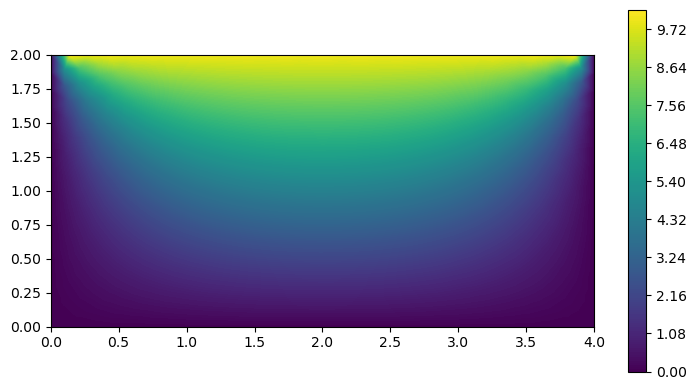

In [88]:
df_x_y = pd.read_csv("./domains/domain_2/mesh001/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh001/Test_domain_2_rectangle_dirichlet_only_001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;
for i in range(len(df_z["sol"].values)):
    df_z["sol"].values[i] = exact_solution(df_x_y["x"].values[i], df_x_y["y"].values[i])


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 200)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar()
plt.savefig(export_path + "rect_dirichlet_only_exact_sol.png", dpi = 500, transparent=True)
plt.show()


<h2> Численное решение </h2>

<h1> Rectangle domain (normal cell 0.05)

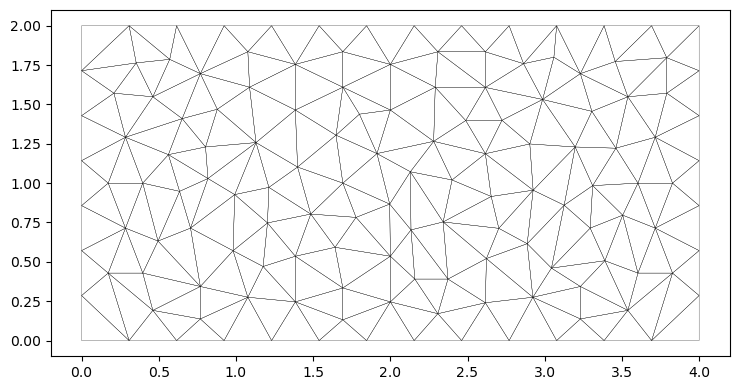

Mean error:  0.41364265496749747


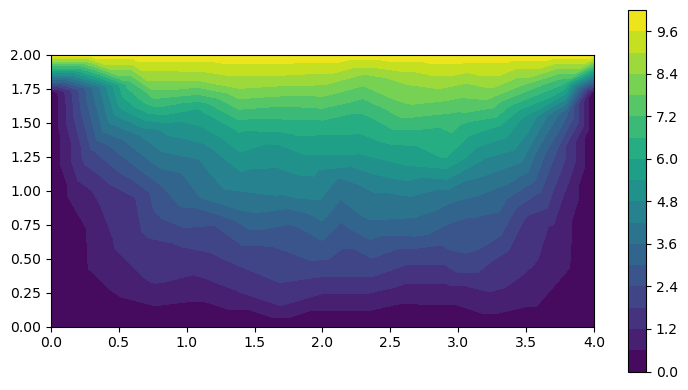

In [90]:
domain_name = "rect_dirichlet_only_005"

df_x_y = pd.read_csv("./domains/domain_2/mesh005/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh005/Test_domain_2_rectangle_dirichlet_only_005_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh005/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;

plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)
plt.savefig(export_path + domain_name + ".png", dpi = 500, transparent=True)
plt.show()
plt.close()

print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 17)


plt.axis("image")
plt.colorbar()
plt.savefig(export_path + domain_name + ".png", dpi = 500, transparent=True)
plt.show()


<h1> Rectangle domain (small cell 0.01)

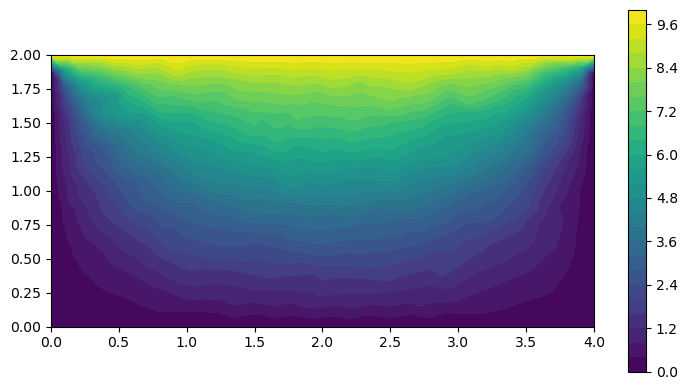

In [85]:
df_x_y = pd.read_csv("./domains/domain_2/mesh001/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh001/Test_domain_2_rectangle_dirichlet_only_001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 25)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar()
plt.savefig(export_path + "rect_dirichlet_only_001.png", dpi = 500, transparent=True)
plt.show()

Mean error:  0.06251372571705428


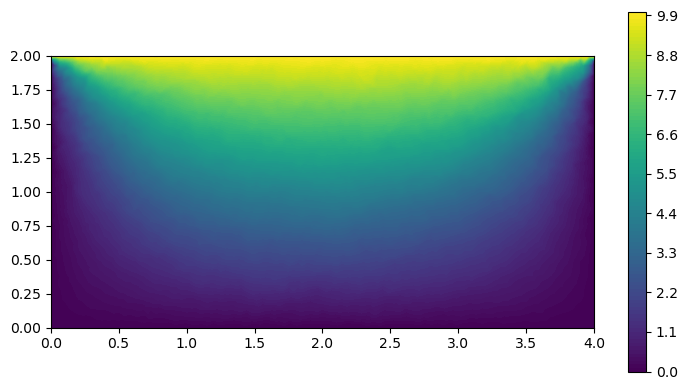

In [86]:
df_x_y = pd.read_csv("./domains/domain_2/mesh0001/mesh_nodes.csv")
df_z = pd.read_csv("./output/domain_2_extra/mesh0001/Test_domain_2_rectangle_dirichlet_only_0001_solution.csv")
df_elements = pd.read_csv("./domains/domain_2/mesh0001/mesh_polygons.csv")
for element in df_elements.values:
    element -= 1;


print_error(df_x_y["x"].values, df_x_y["y"].values, df_z["sol"].values)


plt.rcParams["figure.figsize"] = [7.5, 4]
plt.rcParams["figure.autolayout"] = True

triangulation = tri.Triangulation(df_x_y["x"].values, df_x_y["y"].values, triangles=df_elements.values)
plt.tricontourf(triangulation, df_z["sol"].values, levels = 100)

#plot_fem_mesh(df_x_y["x"].values, df_x_y["y"].values, df_elements.values)

plt.axis("image")
plt.colorbar()
plt.savefig(export_path + "rect_dirichlet_only_0001.png", dpi = 500, transparent=True)
#plt.Axes.set_aspect('equal', adjustable='box', anchor='C')
plt.show()